# Import Libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### From sklearn - Preprocesing 
from sklearn import preprocessing

# Dimension reduction 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# K-fold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# From sklearn - Model creation

from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics 

# Index

1. Reading files and merging features with labels
2. Preprocesing phase <br>
    2.1 Encoding labels<br>
    2.2 Normalization: min_max_scaler<br>
    2.3 Search for outliers in dataset<br>
3. Model Implementation: Decision Tree
        3.1 PCA_80% Training data, 20% test data<br>
        3.2 PCA-DT with fixed value<br>
        3.3 LDA_80% Training data, 20% test data<br>
        3.4 LDA-DT with fixed value<br>
        3.5 Stratified Kfold<br>
        3.6 K-Fold function
        3.7 Grid search Function

-----
# 1. Reading files and merging features with labels

In [79]:
#dataset = pd.read_csv("Genes\data.csv")
dataset = pd.read_csv('/Users/pedrorodriguezdeledesmajimenez/1_Coding/Datasets/RUG_Pattern-recognition_Assignment-2/Task 1/Genres/data.csv')

#labels = pd.read_csv("Genes\labels.csv")
dataset_labels =pd.read_csv('/Users/pedrorodriguezdeledesmajimenez/1_Coding/Datasets/RUG_Pattern-recognition_Assignment-2/Task 1/Genres/labels.csv')

In [80]:
# Merging both datasets and removing first column

dataset = pd.merge(dataset, dataset_labels, on='Unnamed: 0').drop("Unnamed: 0", axis=1)

In [81]:
print(f'Dataset consists of {dataset.shape[0]} input sample vectors, each vector has {dataset.shape[1]} '\
      f'gene features.\nAlso the availbale classes are {len(dataset["Class"].unique())}.'\
      f' The possible choises are {", ".join(val for val in dataset.Class.unique())}.')
class_counts = dataset.Class.value_counts()
print(f'As we can see, we have class imbalance.\n\n{class_counts.to_string()}')

Dataset consists of 801 input sample vectors, each vector has 20532 gene features.
Also the availbale classes are 5. The possible choises are PRAD, LUAD, BRCA, KIRC, COAD.
As we can see, we have class imbalance.

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78


----
# 2. Preprocesing data

##  2.1 Encoding labels

In [82]:
# Encode the labels and updaate values
le = preprocessing.LabelEncoder()
dataset["Class"] = le.fit_transform(dataset_labels.drop("Unnamed: 0", axis=1).values.ravel())

In [83]:
# Let´s store all the labels
keys = le.classes_

# And now store labels with their encoded value 
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
dictionary

{'BRCA': 0, 'COAD': 1, 'KIRC': 2, 'LUAD': 3, 'PRAD': 4}

In [84]:
dataset.Class.value_counts()

0    300
2    146
3    141
4    136
1     78
Name: Class, dtype: int64

## 2.2 Normalization: min_max_scaler

In [85]:
# Lets store the dataset values without the columns titles
x = dataset.iloc[:, :-1].values 

# Let´s create an instance with the normalice function
min_max_scaler = preprocessing.MinMaxScaler()

# Let´s fit the normilice function
x_scaled = min_max_scaler.fit_transform(x)

# Let´s put in the dataframe the values scaled
dataset.iloc[:, :-1] = pd.DataFrame(x_scaled)

In [86]:
stats=pd.DataFrame()
stats["mean"]=dataset.mean()
stats["Std.Dev"]=dataset.std()
stats["Var"]=dataset.var()
stats_2 =stats.sort_values(by=['Var','mean'],ascending=False)
stats_2.head()

,mean,Std.Dev,Var
Class,1.669164,1.531065,2.344160
gene_4773,0.383887,0.411448,0.169290
gene_8891,0.364385,0.398958,0.159168
gene_19913,0.376816,0.395887,0.156726
gene_19313,0.348911,0.390790,0.152717


## 2.3 Search for outliers in dataset

In [87]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
# fit_predict return a numpy array of 1 if not an outlier and -1 if an outlier
outliers = lof.fit_predict(dataset.iloc[:,:-1])

# select all rows that are not outliers
mask = outliers != -1
dataset.shape

#unpack the mask to keep only non-outlier examples
dataset = dataset[[*mask]]

print(f'Data size after removing outliers is: {dataset.shape}.')

Data size after removing outliers is: (796, 20532).


#### Output preprocesing

In [88]:
dataset.shape

(796, 20532)

--------------
# 3. Model Implementation:  KNN

--------

## 3.1 PCA_80% Training data, 20% test data

In [89]:
# PCA with different number of features
k = 9

score_array = []
n_components_array = []

for n_components_PCA in [2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    
    pca = PCA(n_components=n_components_PCA)

    # Apply PCA in input vector
    pca.fit(dataset.iloc[:,:-1]) 

    # Save results in an np.array
    reduced = pca.transform(dataset.iloc[:,:-1])

    # Save labels in an np.array
    x = dataset['Class'].to_numpy()

    # Create final dataframe with reduced dimensions
    dataset_reduced_PCA = pd.DataFrame(np.column_stack((reduced, x)))


    input_data = dataset_reduced_PCA.iloc[:,:-1].values
    label_data = dataset_reduced_PCA.iloc[:,-1].values

    # We split the data  
    X_train, X_test, y_train, y_test = train_test_split(input_data,label_data, test_size=0.2)

    # Build and train the model with the k-vlue
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)

    # We predict the labels of the test data
    y_pred = KNN.predict(X_test)

    # Accuracy of the model
    metrics.accuracy_score(y_test, y_pred)
    
    n_components_array.append(n_components_PCA)
    score_array.append(metrics.accuracy_score(y_test, y_pred))

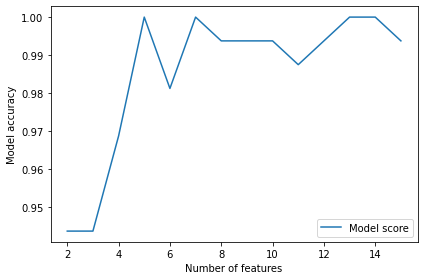

In [90]:
# Plot with regards of components

plt.plot(n_components_array, score_array,label='Model score')
plt.ylabel('Model accuracy')
plt.xlabel('Number of features')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 3.2 KNN-PCA with fixed value of PCA 

In [91]:
# Selected value dimension reduction

pca = PCA(0.70)

# Apply PCA in input vector
pca.fit(dataset.iloc[:,:-1]) 

# Save results in an np.array
reduced = pca.transform(dataset.iloc[:,:-1])

# Save labels in an np.array
x = dataset['Class'].to_numpy()

# Create final dataframe with reduced dimensions
dataset_reduced_PCA = pd.DataFrame(np.column_stack((reduced, x)))

input_data = dataset_reduced_PCA.iloc[:,:-1].values
label_data = dataset_reduced_PCA.iloc[:,-1].values

# We split the data  
X_train, X_test, y_train, y_test = train_test_split(input_data,label_data, test_size=0.2)

In [92]:
# For the n_components selected, lets tune n_neighbors

error = []

# Calculating error for nº neighbors

for i in range(1, 60):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    
    preds = knn.predict(X_test)
    
    squared_error = np.power(y_test - preds,2)
    error.append(np.mean(squared_error))

Text(0, 0.5, 'Mean Squared Error.')

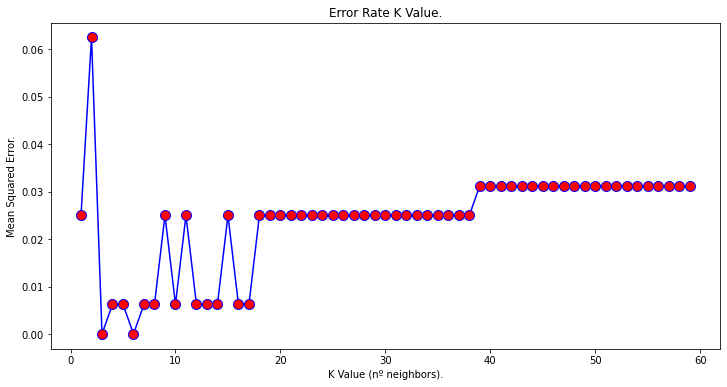

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 60), error, color='blue', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate K Value.')
plt.xlabel('K Value (nº neighbors).')
plt.ylabel('Mean Squared Error.')
#plt.savefig("KNN_error_over_multiple_neighbors.png")

## 3.3 KNN-PCA fixed values

In [94]:
# Build and train the model with the value selected: k= 10
KNN = KNeighborsClassifier(n_neighbors=9)
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [95]:
# We predict the labels of the test data
y_pred = KNN.predict(X_test)

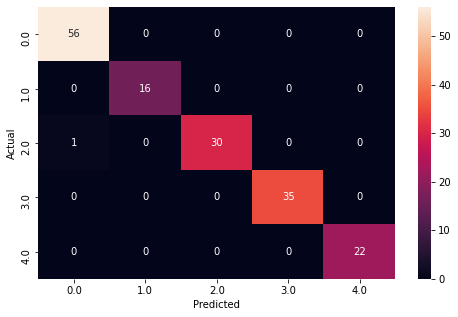

In [96]:
#Confusion matrix to evaluate the model 
plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
#plt.savefig("Confusion_Matrix_KNN.png")
plt.show()

In [97]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

0.99375

In [98]:
print(f"Accuracy:{metrics.accuracy_score(y_test, y_pred)}")

Accuracy:0.99375


In [99]:
print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}')

More metrics about the model.

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        56
         1.0       1.00      1.00      1.00        16
         2.0       1.00      0.97      0.98        31
         3.0       1.00      1.00      1.00        35
         4.0       1.00      1.00      1.00        22

    accuracy                           0.99       160
   macro avg       1.00      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



----------

## 3.4 LDA_80% Training data, 20% test data

In [ ]:
# With different number of features
k = 9

score_array = []
n_components_array_LDA = []

for n_components_LDA in [1,2,3,4]:
    
    lda = LinearDiscriminantAnalysis(n_components=n_components_LDA)

    # Apply PCA in input vector
    lda.fit(dataset.iloc[:,:-1],dataset.iloc[:,-1:].values.ravel()) 

    # Save results in an np.array
    reduced = lda.transform(dataset.iloc[:,:-1].values)

    # Save labels in an np.array
    x = dataset['Class'].to_numpy()

    # Create final dataframe with reduced dimensions
    dataset_reduced_LDA = pd.DataFrame(np.column_stack((reduced, x)))


    input_data = dataset_reduced_LDA.iloc[:,:-1].values
    label_data = dataset_reduced_LDA.iloc[:,-1].values

    # We split the data  
    X_train, X_test, y_train, y_test = train_test_split(input_data,label_data, test_size=0.2)

    # Build and train the model with the k-vlue
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)

    # We predict the labels of the test data
    y_pred = KNN.predict(X_test)

    # Accuracy of the model
    metrics.accuracy_score(y_test, y_pred)
    
    n_components_array_LDA.append(n_components_LDA)
    score_array.append(metrics.accuracy_score(y_test, y_pred))

In [ ]:
# Plot with regards of components

plt.plot(n_components_array_LDA, score_array,label='Model score')
plt.ylabel('Model accuracy')
plt.xlabel('Number of features')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 3.5 KNN-LDA with fixed values

In [ ]:
# Selected value dimension reduction 
lda = LinearDiscriminantAnalysis(n_components=4)

# Apply PCA in input vector
lda.fit(dataset.iloc[:,:-1],dataset.iloc[:,-1]) 

# Save results in an np.array
reduced = lda.transform(dataset.iloc[:,:-1].values)

# Save labels in an np.array
x = dataset['Class'].to_numpy()

# Create final dataframe with reduced dimensions
dataset_reduced_LDA = pd.DataFrame(np.column_stack((reduced, x)))

#For origianl data as input
input_data = dataset.iloc[:,:-1].values
label_data = dataset.iloc[:,-1].values

#For PCA REDUCED data as input
#input_data = dataset_reduced_LDA.iloc[:,:-1].values
#label_data = dataset_reduced_LDA.iloc[:,-1].values

# We split the data  
X_train, X_test, y_train, y_test = train_test_split(input_data,label_data, test_size=0.2)

In [ ]:
# Build and train the model with the value selected: k= 10
KNN = KNeighborsClassifier(n_neighbors=9)
KNN.fit(X_train, y_train)

In [ ]:
# We predict the labels of the test data
y_pred = KNN.predict(X_test)

In [ ]:
#Confusion matrix to evaluate the model 
plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
#plt.savefig("Confusion_Matrix_KNN.png")
plt.show()

In [ ]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

In [ ]:
print(f"Accuracy:{metrics.accuracy_score(y_test, y_pred)}")

In [ ]:
print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}')

In [ ]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

print(f"Accuracy:{metrics.accuracy_score(y_test, y_pred)}")

print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}')

## 3.6 Stratified Kfold

In [ ]:
input_data = dataset_reduced_LDA.iloc[:,:-1].values
label_data = dataset_reduced_LDA.iloc[:,-1].values

In [ ]:
k=9

scores = []
error = []

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

for k in range(9, 10):
    folds = StratifiedKFold(n_splits=k, shuffle = True, random_state = 100)
    
  
    knn = KNeighborsClassifier(n_neighbors=k)

    for train_index, test_index in folds.split(input_data,label_data):
        X_train, X_test, y_train, y_test = input_data[train_index], input_data[test_index], label_data[train_index], label_data[test_index]

        scores.append(get_score(knn, X_train, X_test, y_train, y_test))

        preds = knn.predict(X_test)
        squared_error = np.power(y_test - preds,2)
        error.append(np.mean(squared_error))
            


In [ ]:
# After studying the optimal parameters, we run the model with the selected ones

knn = KNeighborsClassifier(n_neighbors=10)
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state = 100)

scores = []

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

# Index of the spliting
for train_index, test_index in folds.split(input_data,label_data):
    X_train, X_test, y_train, y_test = input_data[train_index], input_data[test_index], label_data[train_index], label_data[test_index]
    scores.append(get_score(knn, X_train, X_test, y_train, y_test))


In [ ]:
# We predict the labels of the test data (Depending on the fold we have different, how we do it with the confusion matrix)
y_pred = knn.predict(X_test)

In [ ]:
#Confusion matrix to evaluate the model 
plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.savefig("Confusion_Matrix_KNN.png")
plt.show()

In [ ]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

In [ ]:
print(f"Accuracy:{metrics.accuracy_score(y_test, y_pred)}")

In [ ]:
print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}')